In [13]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import copy

In [8]:
# Load training and test data from the dataset folder
train_data = pd.read_csv('mnist_train.csv')
test_data = pd.read_csv('mnist_test.csv')

# Separate labels and pixel values
X_train = train_data.iloc[:, 1:].values.reshape(-1, 1, 28, 28) / 255.0  # Normalize pixel values
y_train = train_data.iloc[:, 0].values

X_test = test_data.iloc[:, 1:].values.reshape(-1, 1, 28, 28) / 255.0
y_test = test_data.iloc[:, 0].values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a TensorDataset for the full training data
full_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Define the split ratio (e.g., 90% for training, 10% for validation)
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

print("data is ready")


data is ready


In [2]:
# Confirm the sizes of train, validation, and test datasets
print("Train dataset size:", len(train_loader.dataset))
print("Validation dataset size:", len(val_loader.dataset))
print("Test dataset size:", len(test_loader.dataset))


Train dataset size: 53999
Validation dataset size: 6000
Test dataset size: 9999


In [3]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [17]:
# EarlyStopping class definition
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Model definition
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.7)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = CNNModel().to(device)

print("earlystoping and model is ready")

earlystoping and model is ready


Epoch 1/10, Training Loss: 0.4504, Validation Loss: 0.0874, Validation Accuracy: 97.42%
Epoch 2/10, Training Loss: 0.2045, Validation Loss: 0.0637, Validation Accuracy: 97.95%
Epoch 3/10, Training Loss: 0.1580, Validation Loss: 0.0594, Validation Accuracy: 98.15%
Epoch 4/10, Training Loss: 0.1368, Validation Loss: 0.0560, Validation Accuracy: 98.40%
Epoch 5/10, Training Loss: 0.1205, Validation Loss: 0.0497, Validation Accuracy: 98.52%
Epoch 6/10, Training Loss: 0.1031, Validation Loss: 0.0457, Validation Accuracy: 98.90%
Epoch 7/10, Training Loss: 0.0922, Validation Loss: 0.0486, Validation Accuracy: 98.72%
Epoch 8/10, Training Loss: 0.0816, Validation Loss: 0.0442, Validation Accuracy: 98.87%
Early stopping


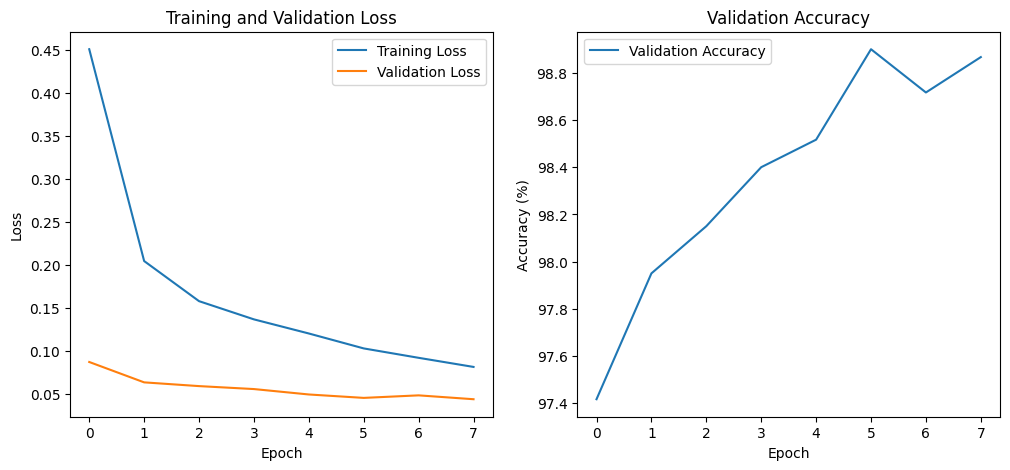

In [18]:
# Define loss, optimizer, and early stopping
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
early_stopping = EarlyStopping(patience=3, min_delta=0.01)  # Adjust patience and min_delta as needed

# Training and Validation Loop with Early Stopping
num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Check early stopping condition
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.show()

In [19]:
# Set the model to evaluation mode
model.eval()
correct, total = 0, 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print test accuracy
test_accuracy = 100 * correct / total
print(f'Accuracy on the test dataset: {test_accuracy:.2f}%')

Accuracy on the test dataset: 99.09%


In [20]:
from sklearn.metrics import classification_report

# Set the model to evaluation mode
model.eval()
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=[
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
])

print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.99      1.00      0.99       980
     Trouser       1.00      1.00      1.00      1135
    Pullover       0.99      0.99      0.99      1032
       Dress       1.00      0.99      0.99      1010
        Coat       0.99      0.99      0.99       982
      Sandal       0.99      0.99      0.99       892
       Shirt       1.00      0.99      0.99       958
     Sneaker       0.99      0.98      0.99      1027
         Bag       0.99      0.99      0.99       974
  Ankle boot       0.99      0.98      0.98      1009

    accuracy                           0.99      9999
   macro avg       0.99      0.99      0.99      9999
weighted avg       0.99      0.99      0.99      9999

